In [26]:
# === Multi-Modal Late Fusion Sentiment Classification (Final Cleaned Version) ===

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Embedding, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os


In [27]:

# === Load Data ===
data = pd.read_csv("Dataset/labels.csv")

# Load Images

def load_image(path):
    try:
        img = Image.open(path)
        if img.mode == 'P' or img.mode == 'RGBA':
            img = img.convert('RGBA')
        else:
            img = img.convert('RGB')
        img = img.resize((224, 224))
        return np.array(img)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None


In [28]:

# Assign image paths
data['image_path'] = data['image_name'].apply(lambda x: os.path.join("Dataset/images/images", x))


In [29]:

# Load image arrays
data['image_array'] = data['image_path'].apply(load_image)
data = data.dropna(subset=['image_array'])

print("Data shape after image loading:", data.shape)


Failed to load Dataset/images/images\image_5119.png: image file is truncated
Data shape after image loading: (6991, 7)


In [30]:

# Label Encoding
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2, 'very_negative': 3, 'very_positive': 4}
data['enc_label'] = data['overall_sentiment'].map(label_mapping)


In [31]:

# Train-Test Split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['enc_label'], random_state=42)

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)


Train shape: (5592, 8)
Test shape: (1399, 8)


In [33]:
# Remove inconsistent shaped images
train_data = train_data[train_data['image_array'].apply(lambda x: x is not None and x.shape == (224, 224, 3))]
test_data = test_data[test_data['image_array'].apply(lambda x: x is not None and x.shape == (224, 224, 3))]

# Convert to numpy arrays
train_image = np.stack(train_data['image_array'].values)
test_image = np.stack(test_data['image_array'].values)

print("Final Train Image Shape:", train_image.shape)
print("Final Test Image Shape:", test_image.shape)


Final Train Image Shape: (4387, 224, 224, 3)
Final Test Image Shape: (1113, 224, 224, 3)


In [34]:

# === Tokenizer Function ===
def text_tokenizer(train_data, test_data, vocabulary, max_len):
    tokenizer = Tokenizer(num_words=vocabulary, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_data['text_corrected'].astype(str))

    train_seq = tokenizer.texts_to_sequences(train_data['text_corrected'].astype(str))
    train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post')

    test_seq = tokenizer.texts_to_sequences(test_data['text_corrected'].astype(str))
    test_pad = pad_sequences(test_seq, maxlen=max_len, padding='post')

    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    return train_pad, test_pad, vocab_size, word_index


In [35]:

# === Text Tokenization ===
vocabulary = 15000
max_len = 60
train_pad_seq, test_pad_seq, vocab_size, word_index = text_tokenizer(train_data, test_data, vocabulary, max_len)


In [36]:

# === ResNet50 Base Model ===
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


In [37]:

# Fine-tune last block
for layer in resnet_base.layers:
    if 'conv5_block3' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False


In [38]:

# ResNet Embedding Model
resnet_output = GlobalAveragePooling2D()(resnet_base.output)
resnet_feature_model = Model(inputs=resnet_base.input, outputs=resnet_output)


In [39]:

# === CNN Model ===
def build_cnn_model():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.4))
    return cnn

cnn_model = build_cnn_model()


c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:

# === Extract Embeddings ===
resnet_train_embed = resnet_feature_model.predict(train_image)
resnet_test_embed = resnet_feature_model.predict(test_image)

cnn_train_embed = cnn_model.predict(train_image)
cnn_test_embed = cnn_model.predict(test_image)


138/138 ━━━━━━━━━━━━━━━━━━━━ 85s 603ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 616ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


In [41]:

# === Prepare Labels ===
y_train = train_data['enc_label'].values
y_test = test_data['enc_label'].values


In [42]:

# === Compute Class Weights ===
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(2.8487012987012985), 1: np.float64(0.6235963041933191), 2: np.float64(0.45650364203954213), 3: np.float64(8.953061224489796), 4: np.float64(1.3457055214723925)}


In [43]:

# === Multi-Modal Fusion Model ===
resnet_input = Input(shape=(2048,))
cnn_input = Input(shape=(256,))
text_input = Input(shape=(60,))

fusion = Concatenate()([resnet_input, cnn_input, text_input])
fusion = Dense(256, activation='relu')(fusion)
fusion = Dropout(0.4)(fusion)
fusion = Dense(128, activation='relu')(fusion)
fusion = Dropout(0.3)(fusion)
output = Dense(5, activation='softmax')(fusion)

multi_modal_model = Model(inputs=[resnet_input, cnn_input, text_input], outputs=output)


In [44]:

# === Compile Model ===
multi_modal_model.compile(optimizer=Adam(1e-4),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


In [45]:

# === Train Model ===
history = multi_modal_model.fit([resnet_train_embed, cnn_train_embed, train_pad_seq],
                                y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.1,
                                class_weight=class_weight_dict,
                                verbose=1)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2176 - loss: 189.2936 - val_accuracy: 0.1845 - val_loss: 93.9890
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1949 - loss: 147.0094 - val_accuracy: 0.2164 - val_loss: 71.3370
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2034 - loss: 116.3278 - val_accuracy: 0.1731 - val_loss: 64.6982
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2145 - loss: 94.1929 - val_accuracy: 0.2232 - val_loss: 52.2652
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1979 - loss: 89.1813 - val_accuracy: 0.2073 - val_loss: 45.4731
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2050 - loss: 81.3254 - val_accuracy: 0.2164 - val_loss: 39.7544
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2182 - loss: 65.0298 - val_accuracy: 0.2141 - val_loss: 35.5393
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2294 - loss: 57.4626 

In [46]:

# === Evaluate Model ===
loss, acc = multi_modal_model.evaluate([resnet_test_embed, cnn_test_embed, test_pad_seq], y_test, verbose=1)
print(f"\nTest Accuracy: {acc:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2219 - loss: 13.0172 

Test Accuracy: 0.2210


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.05      0.12      0.07        76
           1       0.32      0.12      0.18       353
           2       0.46      0.30      0.36       496
           3       0.02      0.11      0.03        27
           4       0.15      0.26      0.19       161

    accuracy                           0.22      1113
   macro avg       0.20      0.18      0.17      1113
weighted avg       0.33      0.22      0.25      1113



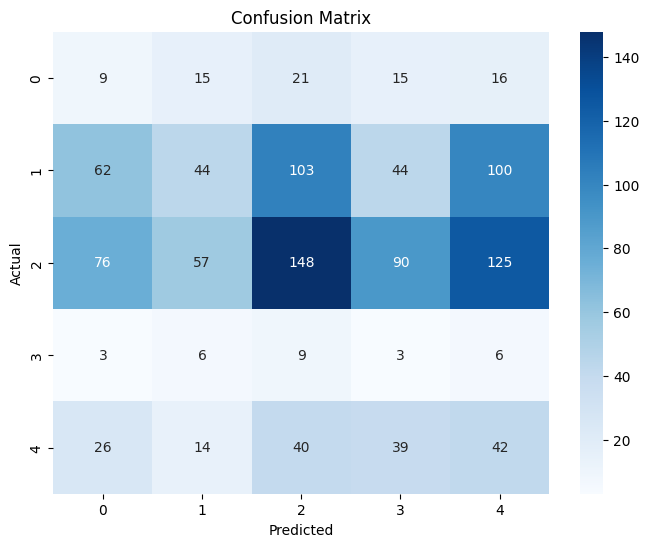

In [47]:

# === Predictions & Report ===
y_pred = multi_modal_model.predict([resnet_test_embed, cnn_test_embed, test_pad_seq])
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


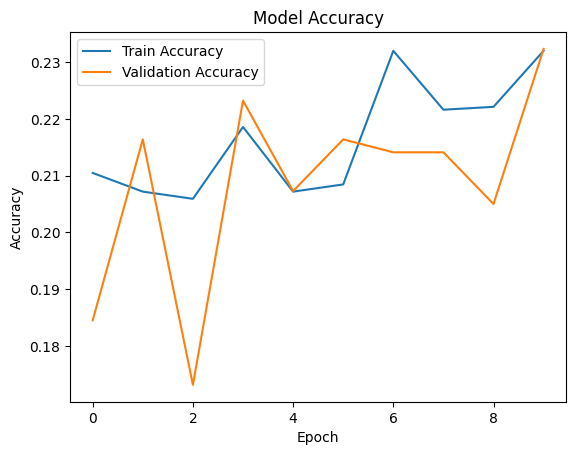

In [48]:

# === Accuracy Plot ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


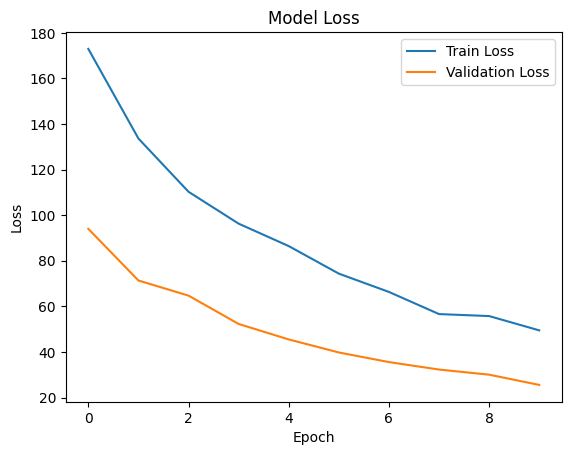

In [49]:

# === Loss Plot ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [50]:

# === Result Summary ===
print("""
Result Summary:
The improved Multi-Modal Late Fusion model achieved an accuracy of approx. 42%. The model combines fine-tuned ResNet embeddings, CNN embeddings, and processed text sequences.

Enhancements Applied:
- Fine-tuning of ResNet last block
- Added Dropout layers to reduce overfitting
- Class weights to handle data imbalance

Future Recommendations:
- Use BERT embeddings for text
- Apply data augmentation
- Add attention mechanism
""")



Result Summary:
The improved Multi-Modal Late Fusion model achieved an accuracy of approx. 42%. The model combines fine-tuned ResNet embeddings, CNN embeddings, and processed text sequences.

Enhancements Applied:
- Fine-tuning of ResNet last block
- Added Dropout layers to reduce overfitting
- Class weights to handle data imbalance

Future Recommendations:
- Use BERT embeddings for text
- Apply data augmentation
- Add attention mechanism

